In [ ]:
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/Shareddrives/EE147'

In [24]:
import numpy as np
import pandas as pd
import scipy.stats as scs
import re
from numpy import genfromtxt
import keras
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv1D, Conv2D,LSTM, BatchNormalization, MaxPooling1D, MaxPooling2D,Reshape, Permute
from keras.utils import np_utils
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
from scipy import signal
import importlib

from utils.cnn_modules import inception_module, inception_module2
import utils.dataprep as dp
import utils.person as person
importlib.reload(dp)

<module 'utils.dataprep' from '/content/drive/Shareddrives/EE147/utils/dataprep.py'>

## Loading the dataset

In [12]:
## Loading the dataset
raw = lambda _: ()
(raw.X_train_valid, raw.y_train_valid, raw.person_train_valid), \
    (raw.X_test, raw.y_test, raw.person_test) = dp.load_data()

(raw.X_train, raw.y_train, raw.person_train), \
    (raw.X_valid, raw.y_valid, raw.person_valid) = \
    dp.split_data(raw.X_train_valid, raw.y_train_valid, raw.person_train_valid)

Loading data from /content/drive/Shareddrives/EE147/project_data/
Training/Valid data shape: (2115, 22, 1000)
Training/Valid target shape: (2115,)
Person train/valid shape: (2115,)
Test data shape: (443, 22, 1000)
Test target shape: (443,)
Person test shape: (443,)
Training Data: (1692, 22, 1000) with labels (1692,) and people (1692,)
Validate Data: (423, 22, 1000) with labels (423,) and people (423,)


In [20]:
print('---- Augmenting Data ----')
prep = lambda _: ()
noise_val = 0.0
prep.X_train, prep.y_train = dp.data_prep(raw.X_train, raw.y_train, noise_val=noise_val)
prep.X_valid, prep.y_valid = dp.data_prep(raw.X_valid, raw.y_valid, noise_val=noise_val)
prep.X_test,  prep.y_test  = dp.data_prep(raw.X_test,  raw.y_test,  noise_val=0.0)

# Quadruple person labels just like data and class labels
prep.person_train = np.hstack([raw.person_train, raw.person_train, raw.person_train, raw.person_train])
prep.person_valid = np.hstack([raw.person_valid, raw.person_valid, raw.person_valid, raw.person_valid])
prep.person_test = np.hstack([raw.person_test, raw.person_test, raw.person_test, raw.person_test])

print('X-train', prep.X_train.shape, 'with labels', prep.y_train.shape, 'and people', prep.y_train.shape)
print('X-valid', prep.X_valid.shape, 'with labels', prep.y_valid.shape, 'and people', prep.y_valid.shape)
print('X-test', prep.X_test.shape, 'with labels', prep.y_test.shape, 'and people', prep.y_test.shape)

---- Augmenting Data ----
X-train (6768, 22, 250) with labels (6768,) and people (6768,)
X-valid (1692, 22, 250) with labels (1692,) and people (1692,)
X-test (1772, 22, 250) with labels (1772,) and people (1772,)


In [21]:
X_train = prep.X_train.reshape(*prep.X_train.shape, 1)
X_train = np.swapaxes(X_train, 1, 2)
y_train = keras.utils.to_categorical(prep.y_train, 4)

X_valid = prep.X_valid.reshape(*prep.X_valid.shape, 1)
X_valid = np.swapaxes(X_valid, 1, 2)
y_valid = keras.utils.to_categorical(prep.y_valid, 4)

X_test = prep.X_test.reshape(*prep.X_test.shape, 1)
X_test = np.swapaxes(X_test, 1, 2)
y_test = keras.utils.to_categorical(prep.y_test, 4)

person_train = prep.person_train
person_valid = prep.person_valid
person_test = prep.person_test

print('---- Reshaping Data ----')
print ("X-train", X_train.shape, "with labels", y_train.shape)
print ("X-valid", X_valid.shape, "with labels", y_valid.shape)
print ("X-test", X_test.shape, "with labels", y_test.shape)

---- Reshaping Data ----
X-train (6768, 250, 22, 1) with labels (6768, 4)
X-valid (1692, 250, 22, 1) with labels (1692, 4)
X-test (1772, 250, 22, 1) with labels (1772, 4)


## Paper CNN

In [ ]:
# Model parameters
dropout = 0.50
lr = 1e-3
epochs = 200

ss=[5,5,5,5,5] #5 found to be optimal this does 5 runs with size 5

#Building the model

cnn_models = []
for s in ss:
  cnn_models.append(Sequential())

i=0;
for s in ss:
  # First block of conv.
  cnn_models[i].add(Conv2D(filters=25, kernel_size=(s,1), input_shape=(250,22,1)))
  cnn_models[i].add(Conv2D(filters=25, kernel_size=(1,22), activation='elu'))
  cnn_models[i].add(Permute((1,3,2), input_shape=(241,1,25)))

  cnn_models[i].add(MaxPooling2D(pool_size=(3,1), padding='same'))
  cnn_models[i].add(BatchNormalization())
  cnn_models[i].add(Dropout(dropout))

  # Second block of conv.
  cnn_models[i].add(Conv2D(filters=50, kernel_size=(s,25), activation='elu'))
  cnn_models[i].add(Permute((1,3,2)))
  cnn_models[i].add(MaxPooling2D(pool_size=(3,1), padding='same'))
  cnn_models[i].add(BatchNormalization())
  cnn_models[i].add(Dropout(dropout))

#   Third block of conv.
  cnn_models[i].add(Conv2D(filters=100, kernel_size=(s,50), activation='elu'))
  cnn_models[i].add(Permute((1,3,2)))
  cnn_models[i].add(MaxPooling2D(pool_size=(3,1), padding='same'))
  cnn_models[i].add(BatchNormalization())
  cnn_models[i].add(Dropout(dropout))

  # Fourth block of conv.
#   cnn_models[i].add(Conv2D(filters=200, kernel_size=(5,100), activation='elu'))
#   cnn_models[i].add(Permute((1,3,2)))
#   cnn_models[i].add(MaxPooling2D(pool_size=(3,1), padding='same'))
#   cnn_models[i].add(BatchNormalization())
#   cnn_models[i].add(Dropout(dropout))

  # FC layer
  cnn_models[i].add(Flatten())
  cnn_models[i].add(Dense(4, activation='softmax'))

  # Defining the optimizer
  # optimizer = keras.optimizers.Adam(learning_rate=lr)
  optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)

#   def scheduler(epoch, lr):
#       if epoch%25 == 0:
#           return lr * 0.5
#       else: return lr

#   callback = keras.callbacks.LearningRateScheduler(scheduler)
  
  checkpoint_filepath = "/content/drive/Shareddrives/EE147/cnn_checkpoint/paperCNN"
  checkpoint = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,)
  
  lr_decay = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=8, verbose=False)
  early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', verbose=False, patience=64)

  callbacks=[checkpoint, lr_decay, early_stopping]

  # Compiling the model
  cnn_models[i].compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['accuracy'])
  i+=1

# Printing the model summary
# cnn_model.summary()

In [ ]:
# The results of networks with 2 layers of conv blocks
i=0
num_trials=1
for s in ss:
  score=0
  for j in range(num_trials):
    cnn_results = cnn_models[i].fit(X_train,
                                y_train,
                                batch_size=32,
                                epochs=epochs,
                                callbacks=callbacks,
                                validation_data=(X_valid, y_valid), verbose=False)

    score += cnn_models[i].evaluate(X_test, y_test, verbose=0)[1]
  print(f'Test accuracy of the CNN model with size {s}:',score/num_trials)
  i+=1

Test accuracy of the CNN model with size 5: 0.7364559769630432
Test accuracy of the CNN model with size 5: 0.7364559769630432
Test accuracy of the CNN model with size 5: 0.7313769459724426
Test accuracy of the CNN model with size 5: 0.75
Test accuracy of the CNN model with size 5: 0.7274266481399536


In [ ]:
cnn_models[0].summary()

Model: "sequential_24"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_78 (Conv2D)           (None, 246, 22, 25)       150       
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 246, 18, 25)       3150      
_________________________________________________________________
permute_54 (Permute)         (None, 246, 25, 18)       0         
_________________________________________________________________
max_pooling2d_54 (MaxPooling (None, 82, 25, 18)        0         
_________________________________________________________________
batch_normalization_54 (Batc (None, 82, 25, 18)        72        
_________________________________________________________________
dropout_54 (Dropout)         (None, 82, 25, 18)        0         
_________________________________________________________________
conv2d_80 (Conv2D)           (None, 78, 1, 50)       

**Paper cnn 2**

made for more granular testing

In [ ]:
# Model parameters
dropout = 0.50
lr = 1e-3
# lr = 1e-4
epochs = 300

Depth=True
ess=[8,8,16,16,22,22]#[4,5,6,7] 5 was found to be
ss = [5,10]

#Building the model

cnn_models = []
for i in range(24):
  cnn_models.append(Sequential())

i=0;
for Depth in (False, True):
  for s in ss:
    for es in ess:
      # First block of conv.
      cnn_models[i].add(Conv2D(filters=25, kernel_size=(s,1), input_shape=(250,22,1)))
      cnn_models[i].add(Conv2D(filters=25, kernel_size=(1,es), activation='elu'))
      cnn_models[i].add(Permute((1,3,2)))

      cnn_models[i].add(MaxPooling2D(pool_size=(3,1), padding='same'))
      cnn_models[i].add(BatchNormalization())
      cnn_models[i].add(Dropout(dropout))

      # Second block of conv.
      cnn_models[i].add(Conv2D(filters=50, kernel_size=(s,25), activation='elu'))
      cnn_models[i].add(Permute((1,3,2)))
      cnn_models[i].add(MaxPooling2D(pool_size=(3,1), padding='same'))
      cnn_models[i].add(BatchNormalization())
      cnn_models[i].add(Dropout(dropout))

    #   Third block of conv.
      cnn_models[i].add(Conv2D(filters=100, kernel_size=(s,50), activation='elu'))
      cnn_models[i].add(Permute((1,3,2)))
      cnn_models[i].add(MaxPooling2D(pool_size=(3,1), padding='same'))
      cnn_models[i].add(BatchNormalization())
      cnn_models[i].add(Dropout(dropout))

      # Fourth block of conv.
      if Depth:
        cnn_models[i].add(Conv2D(filters=200, kernel_size=(5,100), activation='elu'))
        cnn_models[i].add(Permute((1,3,2)))
        cnn_models[i].add(MaxPooling2D(pool_size=(3,1), padding='same'))
        cnn_models[i].add(BatchNormalization())
        cnn_models[i].add(Dropout(dropout))

      # FC layer
      cnn_models[i].add(Flatten())
      cnn_models[i].add(Dense(4, activation='softmax'))

      # Defining the optimizer
      # optimizer = keras.optimizers.Adam(learning_rate=lr)
      optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)

    #   def scheduler(epoch, lr):
    #       if epoch%25 == 0:
    #           return lr * 0.5
    #       else: return lr

    #   callback = keras.callbacks.LearningRateScheduler(scheduler)
      
      checkpoint_filepath = "/content/drive/Shareddrives/EE147/cnn_checkpoint/paperCNN"
      checkpoint = keras.callbacks.ModelCheckpoint(
            checkpoint_filepath,
            monitor="val_accuracy",
            save_best_only=True,
            save_weights_only=True,)
      
      lr_decay = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=8, verbose=False)
      early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', verbose=False, patience=64)

      callbacks=[checkpoint, lr_decay, early_stopping]

      # Compiling the model
      cnn_models[i].compile(loss='categorical_crossentropy',
                        optimizer=optimizer,
                        metrics=['accuracy'])
      i+=1

# Printing the model summary
# cnn_model.summary()

In [ ]:
# The results of networks with 2 layers of conv blocks
i=0
print(len(cnn_models))
for i in range(24):
  if(i%2==0):
    score=0
  cnn_results = cnn_models[i].fit(X_train,
                                y_train,
                                batch_size=32,
                                epochs=epochs,
                                callbacks=callbacks,
                                validation_data=(X_valid, y_valid), verbose=False)

  score += cnn_models[i].evaluate(X_test, y_test, verbose=0)[1]
  if(i%2==1):
    print(f'Test accuracy of the CNN model with config {i}:',score/2)

24
Test accuracy of the CNN model with config 1: 0.7113431394100189
Test accuracy of the CNN model with config 3: 0.7234763205051422
Test accuracy of the CNN model with config 5: 0.7302483022212982
Test accuracy of the CNN model with config 7: 0.6772008836269379
Test accuracy of the CNN model with config 9: 0.6963882744312286
Test accuracy of the CNN model with config 11: 0.6963882744312286
Test accuracy of the CNN model with config 13: 0.68792325258255
Test accuracy of the CNN model with config 15: 0.7158577740192413
Test accuracy of the CNN model with config 17: 0.7164221405982971
Test accuracy of the CNN model with config 19: 0.6735327243804932
Test accuracy of the CNN model with config 21: 0.6811512410640717
Test accuracy of the CNN model with config 23: 0.6980812549591064


In [ ]:
cnn_models[5].summary()

Model: "sequential_54"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_192 (Conv2D)          (None, 246, 22, 25)       150       
_________________________________________________________________
conv2d_193 (Conv2D)          (None, 246, 1, 25)        13775     
_________________________________________________________________
permute_146 (Permute)        (None, 246, 25, 1)        0         
_________________________________________________________________
max_pooling2d_146 (MaxPoolin (None, 82, 25, 1)         0         
_________________________________________________________________
batch_normalization_146 (Bat (None, 82, 25, 1)         4         
_________________________________________________________________
dropout_146 (Dropout)        (None, 82, 25, 1)         0         
_________________________________________________________________
conv2d_194 (Conv2D)          (None, 78, 1, 50)       

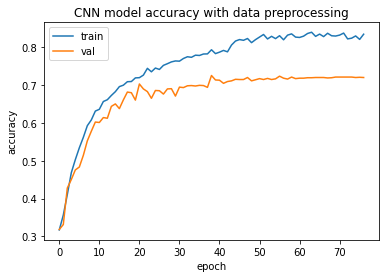

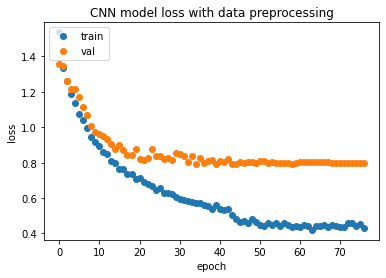

In [ ]:
import matplotlib.pyplot as plt

# list all data in history
#print(history.history.keys())

# summarize history for accuracy
plt.plot(cnn_results.history['accuracy'])
plt.plot(cnn_results.history['val_accuracy'])
plt.title('CNN model accuracy with data preprocessing')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(cnn_results.history['loss'],'o')
plt.plot(cnn_results.history['val_loss'],'o')
plt.title('CNN model loss with data preprocessing')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

## Person Evaluation

In [28]:
def build_paper_model():
  dropout = 0.50
  lr = 1e-3
  # lr = 1e-4
  epochs = 300

  es = 22
  s = 5

  #Building the model

  cnn_model = Sequential()

  # First block of conv.
  cnn_model.add(Conv2D(filters=25, kernel_size=(s,1), input_shape=(250,22,1)))
  cnn_model.add(Conv2D(filters=25, kernel_size=(1,es), activation='elu'))
  cnn_model.add(Permute((1,3,2)))

  cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  cnn_model.add(BatchNormalization())
  cnn_model.add(Dropout(dropout))

  # Second block of conv.
  cnn_model.add(Conv2D(filters=50, kernel_size=(s,25), activation='elu'))
  cnn_model.add(Permute((1,3,2)))
  cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  cnn_model.add(BatchNormalization())
  cnn_model.add(Dropout(dropout))

#   Third block of conv.
  cnn_model.add(Conv2D(filters=100, kernel_size=(s,50), activation='elu'))
  cnn_model.add(Permute((1,3,2)))
  cnn_model.add(MaxPooling2D(pool_size=(3,1), padding='same'))
  cnn_model.add(BatchNormalization())
  cnn_model.add(Dropout(dropout))

  # FC layer
  cnn_model.add(Flatten())
  cnn_model.add(Dense(4, activation='softmax'))

  # Defining the optimizer
  # optimizer = keras.optimizers.Adam(learning_rate=lr)
  optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)

#   def scheduler(epoch, lr):
#       if epoch%25 == 0:
#           return lr * 0.5
#       else: return lr

#   callback = keras.callbacks.LearningRateScheduler(scheduler)
  
  checkpoint_filepath = "/content/drive/Shareddrives/EE147/cnn_checkpoint/paperCNN"
  checkpoint = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,)
  
  lr_decay = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=8, verbose=False)
  early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', verbose=False, patience=64)

  callbacks=[checkpoint, lr_decay, early_stopping]

  # Compiling the model
  cnn_model.compile(loss='categorical_crossentropy',
                    optimizer=optimizer,
                    metrics=['accuracy'])
  
  return cnn_model

In [29]:
train = (X_train, y_train, person_train)
valid = (X_valid, y_valid, person_valid)
test  = (X_test,  y_test,  person_test)
for person_ix in range(9):
  print()
  for everyone in 0, 40, 50:
    person.question_1(build_paper_model(), train, valid, test, person_ix, everyone_epochs=everyone)


Test accuracy of the model (0/50) on person-0: 0.71
Test accuracy of the model (40/50) on person-0: 0.75
Test accuracy of the model (50/50) on person-0: 0.71

Test accuracy of the model (0/50) on person-1: 0.57
Test accuracy of the model (40/50) on person-1: 0.7
Test accuracy of the model (50/50) on person-1: 0.62

Test accuracy of the model (0/50) on person-2: 0.74
Test accuracy of the model (40/50) on person-2: 0.79
Test accuracy of the model (50/50) on person-2: 0.8

Test accuracy of the model (0/50) on person-3: 0.57
Test accuracy of the model (40/50) on person-3: 0.87
Test accuracy of the model (50/50) on person-3: 0.76

Test accuracy of the model (0/50) on person-4: 0.75
Test accuracy of the model (40/50) on person-4: 0.84
Test accuracy of the model (50/50) on person-4: 0.8

Test accuracy of the model (0/50) on person-5: 0.6
Test accuracy of the model (40/50) on person-5: 0.7
Test accuracy of the model (50/50) on person-5: 0.69

Test accuracy of the model (0/50) on person-6: 0.6

# Inception

In [ ]:
# Model parameters
d=.5
ns=[1,1,2,2,3,3,4,4,5,5]
lr = 1e-3
epochs = 100

Inception= True
#Building the model
inc_models=[]

for n in ns:
  inc_models.append(Sequential())

i=0
for n in ns:
  # First block of conv.
  inc_models[i].add(Conv2D(filters=25, kernel_size=(5,1), activation='elu', input_shape=(250,22,1)))
  inc_models[i].add(Conv2D(filters=25, kernel_size=(1,22), padding='same', activation='elu'))
  inc_models[i].add(MaxPooling2D(pool_size=(3,1), padding='same'))
  inc_models[i].add(BatchNormalization())
  inc_models[i].add(Dropout(d))

  # Second block of conv.

  if Inception:
    inputs = tf.keras.Input(shape = inc_models[i].output.shape[1:] )
    layer = inception_module(inputs, 10*n, 10*n, 5*n, 10*n, 3*n, 5*n,"elu")
    model = tf.keras.Model(inputs=inputs, outputs=layer)
    inc_models[i].add(model)
  else:
    inc_models[i].add(Conv2D(filters=50, kernel_size=(10,1), padding='same', activation='elu'))


  inc_models[i].add(MaxPooling2D(pool_size=(3,1), padding='same'))
  inc_models[i].add(BatchNormalization())
  inc_models[i].add(Dropout(d))



  # FC layer
  inc_models[i].add(Flatten())
  inc_models[i].add(Dense(4, activation='softmax'))

  # Defining the optimizer
  # optimizer = keras.optimizers.Adam(learning_rate=lr)
  optimizer = keras.optimizers.SGD(learning_rate=lr, momentum=0.9)

#   def scheduler(epoch, lr):
#       if epoch%25 == 0:
#           return lr * 0.5
#       else: return lr

#   callback = keras.callbacks.LearningRateScheduler(scheduler)

  checkpoint_filepath = "/content/drive/Shareddrives/EE147/cnn_checkpoint/inception"
  checkpoint = keras.callbacks.ModelCheckpoint(
        checkpoint_filepath,
        monitor="val_accuracy",
        save_best_only=True,
        save_weights_only=True,)
  
  lr_decay = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=8, verbose=False)
  early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', verbose=False, patience=64)

  callbacks=[checkpoint, lr_decay, early_stopping]

  # Compiling the model
  inc_models[i].compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['accuracy'])
  i+=1

# # Printing the model summary
# inc_model.summary()

In [ ]:
inc_models[5].summary()

Model: "sequential_88"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_400 (Conv2D)          (None, 246, 22, 25)       150       
_________________________________________________________________
conv2d_401 (Conv2D)          (None, 246, 22, 25)       13775     
_________________________________________________________________
max_pooling2d_260 (MaxPoolin (None, 82, 22, 25)        0         
_________________________________________________________________
batch_normalization_245 (Bat (None, 82, 22, 25)        100       
_________________________________________________________________
dropout_245 (Dropout)        (None, 82, 22, 25)        0         
_________________________________________________________________
model_15 (Functional)        (None, 82, 22, 69)        5454      
_________________________________________________________________
max_pooling2d_262 (MaxPoolin (None, 28, 22, 69)      

In [ ]:
# Training and validating the model
for i in range(10):
  if(i%2==0):
    score=0
  inc_results = inc_models[i].fit(X_train,
                                y_train,
                                batch_size=32,
                                epochs=epochs,
                                callbacks=callbacks,
                                validation_data=(X_valid, y_valid), verbose=False)

  score += cnn_models[i].evaluate(X_test, y_test, verbose=0)[1]
  if(i%2==1):
    print(f'Test accuracy of the inc model with size {1+i//2}:',score/2)

Test accuracy of the inc model with size 1: 0.7119074761867523
Test accuracy of the inc model with size 2: 0.725733608007431
Test accuracy of the inc model with size 3: 0.7299661338329315
Test accuracy of the inc model with size 4: 0.6791760921478271
Test accuracy of the inc model with size 5: 0.6935665905475616


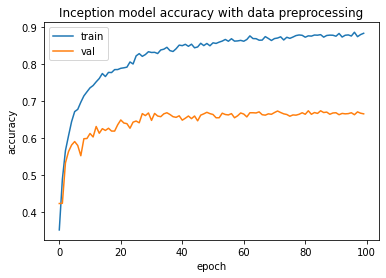

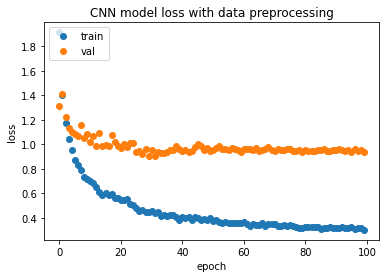

In [ ]:
import matplotlib.pyplot as plt

# list all data in history
#print(history.history.keys())

# summarize history for accuracy
plt.plot(inc_results.history['accuracy'])
plt.plot(inc_results.history['val_accuracy'])
plt.title('Inception model accuracy with data preprocessing')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(inc_results.history['loss'],'o')
plt.plot(inc_results.history['val_loss'],'o')
plt.title('CNN model loss with data preprocessing')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()